In [1]:
import sys
sys.path.append('/Users/harsh/Work/habitat-sim/')
sys.path.append('/Users/harsh/Work/habitat-api/')

In [2]:
cd ..

/coc/pskynet3/hagrawal9/project/sokoban/habitat-api


In [3]:
import gzip
import habitat
import habitat_sim
import habitat_sim.bindings as hsim
import json
import matplotlib.pyplot as plt
import magnum as mn
import numpy as np
import os
import tqdm 

import habitat_sim

from PIL import Image
from typing import Any, Dict, List, Optional, Union

from habitat import Config, logger
from habitat import make_dataset
from habitat.core.simulator import AgentState
# from habitat.tasks.nav.shortest_path_follower import ShortestPathFollower
from habitat.sims.habitat_simulator.actions import HabitatSimActions
from habitat.sims.habitat_simulator.habitat_simulator import HabitatSim
from habitat.utils.visualizations.utils import observations_to_image, images_to_video
from habitat.utils.geometry_utils import (
    angle_between_quaternions,
    quaternion_from_two_vectors,
)
from habitat.tasks.utils import (
    cartesian_to_polar,
    quaternion_from_coeff,
    quaternion_rotate_vector
)

from habitat_baselines.common.base_trainer import BaseRLTrainer
from habitat_baselines.common.baseline_registry import baseline_registry
from habitat_baselines.common.env_utils import construct_envs
from habitat_baselines.common.environments import get_env_class, SokobanRLEnv
from habitat_baselines.common.rollout_storage import RolloutStorage
from habitat_baselines.common.tensorboard_utils import TensorboardWriter
from habitat_baselines.common.utils import (
    batch_obs,
    generate_video,
    linear_decay,
)
from habitat_baselines.config.default import get_config
from habitat_baselines.rl.ppo import PPO, PointNavBaselinePolicy

from habitat_sim.physics import MotionType
from habitat_sim.attributes import PhysicsObjectAttributes
from habitat_sim.helper import *


EPSILON = 1e-6


def action_to_one_hot(action: int) -> np.array:
    one_hot = np.zeros(len(HabitatSimActions), dtype=np.float32)
    one_hot[action] = 1
    return one_hot

%matplotlib inline

In [4]:
content_path = "data/datasets/sokoban/coda/v1/train/content/val_object_5_scene_100_coda.json.gz"

In [5]:
config = get_config("habitat_baselines/config/sokoban/pickup_order_ddppo_obj_5_scene_100.yaml")

In [6]:
config.defrost()
config.SENSORS = ['RGB_SENSOR', 'DEPTH_SENSOR']
config.NUM_PROCESSES = 1
config.TASK_CONFIG.ENVIRONMENT.MAX_EPISODE_STEPS = 1000
config.TASK_CONFIG.TASK.POSSIBLE_ACTIONS = ['STOP', 'MOVE_FORWARD', 'TURN_LEFT', 'TURN_RIGHT', 'GRAB_RELEASE']
config.TASK_CONFIG.DATASET.CONTENT_SCENES = ['val_object_5_scene_10_coda']
config.TASK_CONFIG.ENVIRONMENT.ITERATOR_OPTIONS.SHUFFLE = False
config.freeze()

In [7]:
dataset = make_dataset(config.TASK_CONFIG.DATASET.TYPE, config=config.TASK_CONFIG.DATASET)

2020-07-07 14:17:48,782 Initializing dataset Sokoban-v0


In [8]:
def plot_image(obs):
    color_obs = obs["rgb"][:, :, :3]
    color_obs[190:195, 125:130, :] = [0, 0, 255] 
    depth_obs = obs["depth"]
    depth_obs = ((depth_obs - np.min(depth_obs))/ np.max(depth_obs) * 255.0).astype(np.int)
    depth_obs = np.stack([depth_obs]*3, axis=2)[:, :, :, 0]
    plt.imshow(np.concatenate([color_obs, depth_obs], axis=1))

In [9]:
def shortest_path_example(config, env, mode):
    object_goal_radius = config.SIMULATOR.FORWARD_STEP_SIZE * 4
    object_follower = ShortestPathFollower(env.habitat_env.sim, object_goal_radius, False)
    object_follower.mode = mode
    
    goal_radius = config.SIMULATOR.FORWARD_STEP_SIZE * 2
    goal_follower = ShortestPathFollower(env.habitat_env.sim, goal_radius, False)
    goal_follower.mode = mode

    demonstrations = []
    for episode in range(len(env.habitat_env.episodes)):
        try:
            observations = env.reset()
            dem = {}
            dem['episode_id'] = env.habitat_env.current_episode.episode_id
            dem['actions'] = []
            dem['is_grab_success'] = True
            # print(dem['episode_id'])
            images = []
            while not env.habitat_env.episode_over:
                position = np.array(env.habitat_env.sim._sim.get_translation(1))
                best_action = object_follower.get_next_action(
                    position
                )

                if best_action is None:
                    break 

                dem['actions'].append(env.habitat_env.task.get_action_name(best_action))
                observations, reward, done, infos = env.step(action={'action': best_action})
                # print(observations)
                im = observations["rgb"]
                im[190:195, 125:130, :] = [0, 0, 255] 
                images.append(im)

#             # Call grab action
#             observations, reward, done, infos = env.step(action={'action':4})
#             im = observations["rgb"]
#             im[190:195, 125:130, :] = [0, 0, 255] 
#             images.append(im)

#             dem['actions'].append(env.habitat_env.task.get_action_name(4))
#             success = observations['gripped_object_id'] != -1

#             if not success:
#                 dem['is_grab_success'] = False
#                 # images_to_video(images, 'data/videos', 'trajectory' + str(episode))
#                 # dem['videos'] = 'data/videos/trajectories' + str(episode)
#                 dem['infos'] = infos
#                 dem['reward'] = reward
#                 dem['success'] = False
#                 dem['done'] = done

#                 yield False, observations, reward, done, infos, dem, images

#             while not env.habitat_env.episode_over:
#                 position = np.array(env.habitat_env.sim._sim.get_translation(1))
#                 best_action = goal_follower.get_next_action(
#                     env.habitat_env.current_episode.goals[0].position, object_id=1
#                 )
#                 if best_action is None:
#                     best_action = 4
#                     dem['actions'].append(env.habitat_env.task.get_action_name(best_action))
#                     observations, reward, done, infos = env.step(action={'action': best_action})
#                     im = observations["rgb"]
#                     im[190:195, 125:130, :] = [0, 0, 255] 
#                     images.append(im)
#                     break

#                 dem['actions'].append(env.habitat_env.task.get_action_name(best_action))
#                 observations, reward, done, infos = env.step(action={'action': best_action})
#                 im = observations["rgb"]
#                 im[190:195, 125:130, :] = [0, 0, 255] 
#                 images.append(im)

#             # dem['videos'] = 'data/videos/trajectories' + str(episode)
#             dem['infos'] = infos
#             dem['reward'] = reward
#             dem['success'] = True
#             dem['done'] = done

            # images_to_video(images, 'data/videos', 'trajectory' + str(episode))
            yield True, observations, reward, done, infos, dem, images
        except Exception as e:
            yield False, observations, reward, done, infos, dem, images
        

In [21]:
env.close()

In [10]:
env = SokobanRLEnv(config=config, dataset=dataset)

2020-07-07 14:17:51,753 initializing sim SokobanSim-v0


seed: 100


2020-07-07 14:17:53,257 Initializing task Sokoban-v0


Possible Actions: OrderedDict([('STOP', <habitat.tasks.nav.nav.StopAction object at 0x7feeb0386e10>), ('MOVE_FORWARD', <habitat.tasks.nav.nav.MoveForwardAction object at 0x7feeb0386e80>), ('TURN_LEFT', <habitat.tasks.nav.nav.TurnLeftAction object at 0x7feeb0386e48>), ('TURN_RIGHT', <habitat.tasks.nav.nav.TurnRightAction object at 0x7feeb0386eb8>), ('GRAB_RELEASE', <habitat.tasks.sokoban.sokoban_task.GrabOrReleaseAction object at 0x7feeb0386f28>)])


In [10]:
count = 0
demonstrations = []
episode_images = []
for i, (val, obs, reward, done, infos, dem, images) in enumerate(shortest_path_example(config.TASK_CONFIG, env, "exact_gradient")):
    if val == False or done==False:
        count += 1
        # images_to_video(images, 'data/videos', 'trajectory'+str(dem['episode_id']))
    # print(obs)
    # print(obs['gripped_object_id'], infos, done, reward)
    print("i: {}, id:{}, success: {}, count={}, done={}, dist_to_goal: {}".format(
        i, dem['episode_id'], val, count, done, infos['object_distance_to_goal']
    ), end="\r")
    episode_images.append(images)
    demonstrations.append(dem)
    

NameError: name 'ShortestPathFollower' is not defined

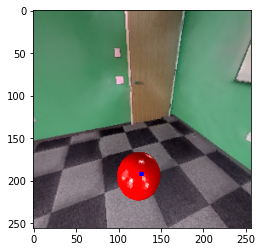

In [24]:
plt.imshow(episode_images[0][-1])

In [ ]:
# potential issues: 
# will not handle geodesic distances really well. #7743
# will not handle cases where the object is spawned too close. 

In [14]:
demonstrations_dict = {}
for demo in demonstrations:
    if 'infos' in demo:
        if 'object_goals' in demo['infos']:
            demo['infos']['object_goals'][1] = np.array(demo['infos']['object_goals'][1]).tolist()
        
    demonstrations_dict[demo['episode_id']] = demo

In [15]:
with gzip.open('data/datasets/sokoban/coda/v1/train/content/coda_hard.json.gz', "rt") as f:
    episodes = json.load(f)

In [16]:
'actions', 'is_grab_success', 'success', 'done'
for episode_id,demo  in demonstrations_dict.items():
    episode_id = demo['episode_id']
    episodes['episodes'][int(episode_id)]['demonstrations'] = demo

In [17]:
with gzip.open('data/datasets/sokoban/coda/v1/train/content/coda_hard_wdemo.json.gz', "wt") as f:
    json.dump(episodes, f)

In [19]:
episodes

{'episodes': [{'episode_id': '0',
   'scene_id': 'data/scene_datasets/coda/coda.glb',
   'start_position': [4.95595121383667,
    0.0824393481016159,
    -5.499965667724609],
   'start_rotation': [0.0, 0.4515811502933502, 0.0, 0.8922300934791565],
   'info': {},
   'object_templates': [{'object_key': 'sphere',
     'object_template': 'data/test_assets/objects/sphere.glb'}],
   'objects': [{'object_id': 1,
     'object_key': 'sphere',
     'position': [2.214710235595703, 0.03243936598300934, -2.4667840003967285],
     'rotation': [0.0, 0.4515811502933502, 0.0, 0.8922300934791565]}],
   'goals': [{'position': [6.498198509216309,
      0.0824393481016159,
      -1.2550601959228516],
     'rotation': [0.0, 0.4515811502933502, 0.0, 0.8922300934791565]}],
   'demonstrations': {'episode_id': '0',
    'actions': ['TURN_LEFT',
     'TURN_LEFT',
     'TURN_LEFT',
     'TURN_LEFT',
     'TURN_LEFT',
     'TURN_LEFT',
     'TURN_LEFT',
     'TURN_LEFT',
     'MOVE_FORWARD',
     'MOVE_FORWARD',
  